In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchio as tio
import torchvision.transforms as transforms


from modules import Evaluator3D, MRIDataset, MRIDatasets, UNet3D
from modules.Transforms import *
from modules.LossFunctions import DC_and_CE_loss, GDiceLossV2
from modules.Utils import *

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# There are multiple data folders belong to same dataset. Each of them processed in different ways.
# Therefore, path of the data and its name explicitly are defined.
dataset_ = MRIDatasets.FeTA_BalancedDistribution
dataset_path =os.path.join('data2', 'feta_pro2')
cv_ = "cv3" # 5-fold cross-validation. Folds [cv1-cv5]

transform_train = None
transform_eval = None

dataset_train = MRIDatasets.FeTA_BalancedDistribution
dataset_path_train = os.path.join('data2', 'feta_pro2')
dataset_val = MRIDatasets.FeTA_BalancedDistribution
dataset_path_val = os.path.join('data2', 'feta_pro2')
dataset_test = MRIDatasets.FeTA_BalancedDistribution
dataset_path_test = os.path.join('data2', 'feta_pro2')


# Split dataset.
train = MRIDataset(dataset_train, "train", dataset_path_train, transform=transform_train)
val = MRIDataset(dataset_val, "val", dataset_path_val, transform=transform_eval)
test = MRIDataset(dataset_test, "test", dataset_path_test, transform=transform_eval)

torch.manual_seed(0)
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=1)
val_loader = torch.utils.data.DataLoader(dataset=val, batch_size=1)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=1)

In [3]:
model = UNet3D().to(device)
criterion = DC_and_CE_loss({'batch_dice': True, 'smooth': 1e-5, 'do_bg': False, 'square': False}, {})
model.load_state_dict(torch.load("output/UNet3D/Iteration9/run8/weights/59_model.pth"))

<All keys matched successfully>

Validation : 100%|███████████████████████████████████████████████████████| 10/10 [01:28<00:00,  8.90s/it, Loss: 1.2235]


Average Validation Dice Scorestensor([0.9944, 0.8053, 0.7508, 0.9174, 0.8561, 0.8749, 0.8651, 0.8324])


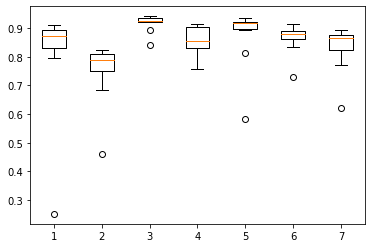

,participant_id,Pathology,Gestational age,eCSF,Gray Matter,White Matter,Ventricles,Cerrebilium,Deep Gray Matter,Brain Stem
0,sub-019,Pathological,29.2,0.861257,0.736387,0.929683,0.844231,0.936363,0.887868,0.874051
1,sub-021,Pathological,26.1,0.796206,0.682999,0.892660,0.842228,0.813883,0.875970,0.810067
2,sub-022,Pathological,20.0,0.251930,0.460553,0.841726,0.869159,0.583248,0.834107,0.621752
3,sub-034,Neurotypical,28.7,0.909190,0.787140,0.937824,0.909618,0.930439,0.915569,0.858419
4,sub-039,Neurotypical,24.3,0.903278,0.825158,0.938625,0.893110,0.893418,0.857728,0.770516
5,sub-067,Pathological,29.0,0.893914,0.818786,0.941320,0.912743,0.922595,0.903111,0.889022
6,sub-068,Neurotypical,31.5,0.888157,0.790009,0.919906,0.800444,0.922482,0.729797,0.874768
7,sub-072,Neurotypical,25.9,0.828741,0.809278,0.926475,0.758026,0.916020,0.882222,0.865146
8,sub-074,Pathological,23.3,0.882436,0.808026,0.923209,0.824686,0.912368,0.874937,0.864971
9,sub-077,Pathological,26.9,0.838046,0.789748,0.922738,0.906703,0.917759,0.889351,0.894840


In [4]:
tissue_classes = ["Background", "eCSF", "Gray Matter", "White Matter", "Ventricles", 
                  "Cerrebilium", "Deep Gray Matter", "Brain Stem"]

# Evaluate the last model on validation set.
evaluator = Evaluator3D(criterion, model, (128, 128, 128), val_loader)
val_loss, val_scores = evaluator.evaluate()
avg_val_scores = sum(val_scores) / len(val_scores)
# Convert Tensors to list.
val_scores = [score.tolist() for score in val_scores]
# Combine results and subject information to examine data carefully. 
val_results = pd.DataFrame(val_scores, index=val.meta_data["participant_id"], columns=tissue_classes)
val_results.drop(columns="Background", inplace=True)
val_results = pd.merge(val.meta_data, val_results, on=["participant_id"])

# Display results.
print(f"Average Validation Dice Scores{avg_val_scores}")
plt.boxplot(val_results.iloc[:, 3:]) # Plot only dice scoress in box plot.
plt.show()
val_results

Validation : 100%|███████████████████████████████████████████████████████| 10/10 [01:31<00:00,  9.13s/it, Loss: 1.2306]


Average Test Dice Scorestensor([0.9932, 0.7027, 0.6883, 0.8990, 0.8822, 0.8017, 0.8222, 0.7622])


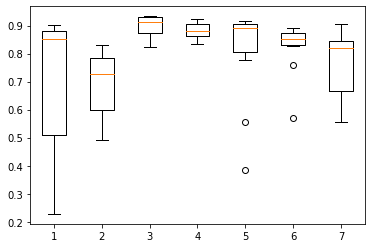

,participant_id,Pathology,Gestational age,eCSF,Gray Matter,White Matter,Ventricles,Cerrebilium,Deep Gray Matter,Brain Stem
0,sub-023,Pathological,23.7,0.323216,0.498520,0.824323,0.880574,0.383098,0.757534,0.555712
1,sub-024,Pathological,30.4,0.829179,0.698468,0.885954,0.909214,0.892563,0.851228,0.833373
2,sub-025,Pathological,24.2,0.227864,0.493101,0.863545,0.922684,0.778711,0.828118,0.622126
3,sub-035,Neurotypical,32.8,0.803151,0.666129,0.907581,0.864222,0.907175,0.843495,0.664555
4,sub-040,Neurotypical,27.3,0.882396,0.758415,0.932154,0.833989,0.886011,0.877277,0.805107
5,sub-075,Pathological,29.0,0.881685,0.782851,0.932474,0.897580,0.914773,0.890582,0.878971
6,sub-076,Neurotypical,23.2,0.872531,0.782730,0.914362,0.878792,0.886779,0.863353,0.841739
7,sub-078,Pathological,24.0,0.412816,0.574365,0.868017,0.859490,0.556096,0.569893,0.672274
8,sub-079,Neurotypical,29.1,0.903305,0.797175,0.928371,0.861353,0.906473,0.851615,0.843882
9,sub-080,Pathological,26.9,0.891207,0.830918,0.933289,0.913807,0.905115,0.888989,0.904402


In [5]:
# Evaluate the last model on validation set. 
# If cross-validation was used test set is not available for evaluation.
evaluator = Evaluator3D(criterion, model, (128, 128, 128), test_loader)
test_loss, test_scores = evaluator.evaluate()
avg_test_scores = sum(test_scores) / len(test_scores)
# Convert Tensors to list.
test_scores = [score.tolist() for score in test_scores]
# Combine results and subject information to examine data carefully. 
test_results = pd.DataFrame(test_scores, index=test.meta_data["participant_id"], columns=tissue_classes)
test_results.drop(columns="Background", inplace=True)
test_results = pd.merge(test.meta_data, test_results, on=["participant_id"])

# Display results.
print(f"Average Test Dice Scores{avg_test_scores}")
plt.boxplot(test_results.iloc[:, 3:])
plt.show()
test_results

Validation : 100%|███████████████████████████████████████████████████████| 58/58 [09:27<00:00,  9.79s/it, Loss: 1.2181]


Average Test Dice Scorestensor([0.9955, 0.8651, 0.7793, 0.9311, 0.8932, 0.9177, 0.9105, 0.8914])


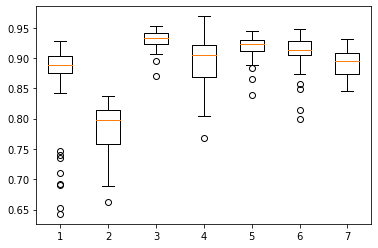

,participant_id,Pathology,Gestational age,eCSF,Gray Matter,White Matter,Ventricles,Cerrebilium,Deep Gray Matter,Brain Stem
0,sub-001,Pathological,27.9,0.893639,0.780185,0.938313,0.898039,0.926022,0.919207,0.877660
1,sub-002,Pathological,28.2,0.882966,0.719647,0.907881,0.903480,0.864937,0.892675,0.854261
2,sub-003,Pathological,27.4,0.873932,0.771799,0.915053,0.942616,0.900599,0.916253,0.871959
3,sub-004,Pathological,25.5,0.734550,0.780116,0.926975,0.914838,0.839662,0.943468,0.847094
4,sub-005,Pathological,22.6,0.710545,0.721094,0.928691,0.860217,0.901462,0.930656,0.867516
5,sub-006,Pathological,24.9,0.882937,0.801220,0.920183,0.937383,0.931807,0.927210,0.922012
6,sub-008,Pathological,25.2,0.746555,0.699626,0.922214,0.933191,0.913722,0.947521,0.849697
7,sub-010,Pathological,27.3,0.928345,0.814323,0.937489,0.936916,0.923217,0.917687,0.892080
8,sub-011,Pathological,27.6,0.906927,0.782784,0.932308,0.904458,0.913622,0.917658,0.890091
9,sub-012,Pathological,25.9,0.905834,0.688959,0.926153,0.923608,0.931696,0.923251,0.885470


In [9]:
# Evaluate the last model on validation set. 
# If cross-validation was used test set is not available for evaluation.
evaluator = Evaluator3D(criterion, model, (128, 128, 128), train_loader)
train_loss, train_scores = evaluator.evaluate()
avg_train_scores = sum(train_scores) / len(train_scores)
# Convert Tensors to list.
train_scores = [score.tolist() for score in train_scores]
# Combine results and subject information to examine data carefully. 
train_results = pd.DataFrame(train_scores, index=train.meta_data["participant_id"], columns=tissue_classes)
train_results.drop(columns="Background", inplace=True)
train_results = pd.merge(train.meta_data, train_results, on=["participant_id"])

# Display results.
print(f"Average Test Dice Scores{avg_train_scores}")
plt.boxplot(train_results.iloc[:, 3:])
plt.show()
train_results

In [8]:
train_results

,participant_id,Pathology,Gestational age,eCSF,Gray Matter,White Matter,Ventricles,Cerrebilium,Deep Gray Matter,Brain Stem
0,sub-001,Pathological,27.9,0.893639,0.780185,0.938313,0.898039,0.926022,0.919207,0.877660
1,sub-002,Pathological,28.2,0.882966,0.719647,0.907881,0.903480,0.864937,0.892675,0.854261
2,sub-003,Pathological,27.4,0.873932,0.771799,0.915053,0.942616,0.900599,0.916253,0.871959
3,sub-004,Pathological,25.5,0.734550,0.780116,0.926975,0.914838,0.839662,0.943468,0.847094
4,sub-005,Pathological,22.6,0.710545,0.721094,0.928691,0.860217,0.901462,0.930656,0.867516
5,sub-006,Pathological,24.9,0.882937,0.801220,0.920183,0.937383,0.931807,0.927210,0.922012
6,sub-008,Pathological,25.2,0.746555,0.699626,0.922214,0.933191,0.913722,0.947521,0.849697
7,sub-010,Pathological,27.3,0.928345,0.814323,0.937489,0.936916,0.923217,0.917687,0.892080
8,sub-011,Pathological,27.6,0.906927,0.782784,0.932308,0.904458,0.913622,0.917658,0.890091
9,sub-012,Pathological,25.9,0.905834,0.688959,0.926153,0.923608,0.931696,0.923251,0.885470
